In [1]:
# Data cleaning and plots
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

# Train model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

# Data Processing


The number of records in the Dataset is 175,341 records from the different types, attack and normal.

attack_cat: This dataset has nine types of attacks, namely, Fuzzers, Analysis, Backdoors, DoS, Exploits, Generic, Reconnaissance, Shellcode and Worms.

Label: 0 for normal and 1 for attack records

In [2]:
initial_data = pd.read_csv('UNSW_NB15.csv')
initial_data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


## Data Preprocessing



### Check missing values

In [3]:
initial_data.shape

(175341, 45)

In [4]:
data_to_use = initial_data.dropna()
data_to_use.shape

(175341, 45)

### Check imbalanced issue on y

In [5]:
X = data_to_use.drop(axis=1, columns=['attack_cat'])
X = X.drop(axis=1, columns=['label'])

y1 = data_to_use['label'].values
y2 = data_to_use['attack_cat'].values

In [6]:
def data_ratio(y):
    unique, count = np.unique(y, return_counts=True)
    ratio = round(count[0]/count[1], 1)
    return f'{ratio}:1 ({count[0]}/{count[1]})'

In [7]:
print('The class ratio for y1:', data_ratio(y1))

The class ratio for y1: 0.5:1 (56000/119341)


### Load Data

In [8]:
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.3, random_state=1)

### Transform training and testing data

In [9]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns

In [10]:
numerical_cols

Index(['id', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl',
       'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit',
       'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat',
       'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports'],
      dtype='object')

In [11]:
categorical_cols

Index(['proto', 'service', 'state'], dtype='object')

### Column Transformer

The ColumnTransformer is a class in the scikit-learn library that allows you to selectively apply data preparation transforms

In [12]:
t = [('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
    ('scale', StandardScaler(), numerical_cols)]

col_trans = ColumnTransformer(transformers=t)
col_trans.fit(X_train)

ColumnTransformer(transformers=[('ohe',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 Index(['proto', 'service', 'state'], dtype='object')),
                                ('scale', StandardScaler(),
                                 Index(['id', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl',
       'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit',
       'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat',
       'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports'],
      dtype='object'))])

In [13]:
X_train_transform = col_trans.transform(X_train)
X_test_transform = col_trans.transform(X_test)

In [14]:
X_train_transform.shape

(122738, 189)

In [15]:
X_test_transform.shape

(52603, 189)

### Apply Label Encoder

In [16]:
pd.unique(y1)

array([0, 1])

In [17]:
target_trans = LabelEncoder()
target_trans.fit(y1_train)
y1_train_transform = target_trans.transform(y1_train)
y1_test_transform = target_trans.transform(y1_test)

In [18]:
y1_train_transform

array([1, 1, 1, ..., 1, 0, 1])

### Synthetic Minority Over-sampling Technique 

In [19]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_transform, y1_train_transform)

### Recursive Feature Elimination 

In [20]:
rf_model = LogisticRegression(random_state=123, max_iter=5000)
rfe = RFE(estimator=rf_model, n_features_to_select=20)
rfe.fit(X_resampled, y_resampled)

X_rfe_train = rfe.transform(X_resampled)
X_rfe_test = rfe.transform(X_test_transform)

### Principle Component Analysis

In [21]:
pca = PCA(n_components=10)
pca.fit(X_rfe_train)

X_pca_train = pca.transform(X_rfe_train)
X_pca_test = pca.transform(X_rfe_test)

## Apply ML Models (Attack or Normal Response)

In [22]:
models = [('LogisticRegression', LogisticRegression(random_state=123, max_iter=5000)),
          ('DecisionTree', DecisionTreeClassifier(random_state=123)),
          ('RandomForest', RandomForestClassifier(random_state=123)),
          ]

for model_name, clf in models:
    print(clf)

LogisticRegression(max_iter=5000, random_state=123)
DecisionTreeClassifier(random_state=123)
RandomForestClassifier(random_state=123)


In [23]:
model_names_list = []
cv_fit_time_mean_list = []
cv_accuracy_mean_list = []
cv_precision_mean_list = []
cv_recall_mean_list = []
cv_f1_mean_list = []

test_accuracy_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []



for model_name, clf in models:
    
    # ==== Step 1: Cross-validation =====
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    scoring = ['accuracy', 'precision_micro', 'recall_micro', 'f1_micro']
    cv_results = cross_validate(estimator=clf,
                                X=X_pca_train,
                                y=y_resampled,
                                scoring=scoring,
                                cv=cv,
                                return_train_score=False)

    cv_fit_time_mean = cv_results['fit_time'].mean()
    cv_accuracy_mean = cv_results['test_accuracy'].mean()
    cv_precision_mean = cv_results['test_precision_micro'].mean()
    cv_recall_mean = cv_results['test_recall_micro'].mean()
    cv_f1_mean = cv_results['test_f1_micro'].mean()

    model_names_list.append(model_name)
    cv_fit_time_mean_list.append(cv_fit_time_mean)
    cv_accuracy_mean_list.append(cv_accuracy_mean)
    cv_precision_mean_list.append(cv_precision_mean)
    cv_recall_mean_list.append(cv_recall_mean)
    cv_f1_mean_list.append(cv_f1_mean)

    # ==== Step 2: Evaluation on Testing data =====

    clf.fit(X=X_pca_train, y=y_resampled)

    y_pred_class = clf.predict(X=X_pca_test)  
    
    y_pred_score = clf.predict_proba(X=X_pca_test)[:, 1]

    accuracy_ontest = accuracy_score(y_true=y1_test_transform, y_pred=y_pred_class)
    
    precision_ontest = precision_score(y_true=y1_test_transform, y_pred=y_pred_class, average = 'micro')
    
    recall_ontest = recall_score(y_true=y1_test_transform, y_pred=y_pred_class, average = 'micro')
    
    f1_ontest = f1_score(y_true=y1_test_transform, y_pred=y_pred_class, average = 'micro')

    test_accuracy_list.append(accuracy_ontest)
    test_precision_list.append(precision_ontest)
    test_recall_list.append(recall_ontest)
    test_f1_list.append(f1_ontest)

### Model Comparison

In [24]:
results_dict = {'Model Name': model_names_list,
                'Fit Time': cv_fit_time_mean_list,
                'CV Accuracy mean': cv_accuracy_mean_list,
                'CV Precision mean': cv_precision_mean_list,
                'CV Recall mean': cv_recall_mean_list,
                'CV F1 mean': cv_f1_mean_list,
                'Test Accuracy': test_accuracy_list,
                'Test Precision': test_precision_list,
                'Test Recall': test_recall_list,
                'Test F1': test_f1_list,
                }

results_df = pd.DataFrame(results_dict)

results_df.sort_values(by='Test F1', ascending=False)

,Model Name,Fit Time,CV Accuracy mean,CV Precision mean,CV Recall mean,CV F1 mean,Test Accuracy,Test Precision,Test Recall,Test F1
2,RandomForest,25.860731,0.970579,0.970579,0.970579,0.970579,0.976294,0.976294,0.976294,0.976294
1,DecisionTree,1.889196,0.969149,0.969149,0.969149,0.969149,0.973633,0.973633,0.973633,0.973633
0,LogisticRegression,0.730273,0.914527,0.914527,0.914527,0.914527,0.916640,0.916640,0.916640,0.916640


### Confusion Matrix

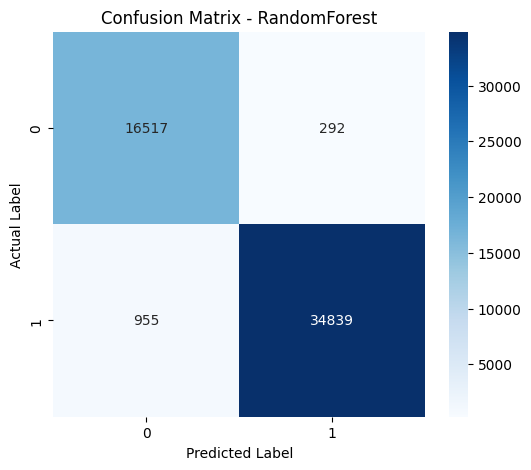

In [25]:
cm = confusion_matrix(y1_test_transform, y_pred_class)
    
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y1_test_transform), yticklabels=np.unique(y1_test_transform))
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title(f"Confusion Matrix - {model_name}")
plt.show()

## Final Verdict

We choose F1 score as the evaluation metric on testing data to show the performance of the trained model. According to the above table, we could see that `Random Forest` model outperforms others because it has the highest F1 score, but all models are near each other so all are valid and acceptable models.